In [282]:
%load_ext autoreload
%autoreload 2
from Ge_calculation import GAP, MD_run
from Ge_analysis import *
import numpy as np
import os
from ase.atoms import Atoms
from quippy.potential import Potential
from quippy.descriptors import Descriptor
from ase.io import read
from ase.io.extxyz import read_xyz, write_xyz
import pymatgen.core.periodic_table as pt
import pymatgen.io.ase as pase
from sklearn import decomposition
from pyuoi.decomposition import CUR
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
os.chdir('/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing')
my = GAP('Si_myDB_64_125_216_train.xyz',
         val_file='Si_myDB_64_125_216_validate.xyz',
         pot='/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/Si_myDB_liqamo_loose.xml')

Training set structure count: 281
Validation set structure count: 70
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'inter', 'hiT_amorph', 'liq', 'hiT_liq']


In [41]:
myDB = list(read_xyz('Si_myDB_64_125_216_train.xyz', index=slice(0, None)))

def mult_min(v, Fmin):
    if v < Fmin:
        return Fmin
    else:
        return v
vmult_min = np.vectorize(mult_min)

for i in myDB:
    f = 0.1; Fmin = 0.01
    F = np.linalg.norm(i.get_array('dft_forces'), axis=1)
    s = f*vmult_min(F, Fmin)
    i.set_array('force_atom_sigma', s)

In [42]:
write_xyz('Si_myDB_fdreg_f0.1_Fmin0.01.xyz', myDB)

In [4]:
litDB = GAP('../Si_litDB_amoliq/gp_iter6_liqamo.xyz',
            val_file='Si_myDB_64_125_216_validate.xyz',
            pot='../Si_litDB_amoliq/Si_litDB_liqamo.xml',
            parameter_names=['dft_energy', 'dft_forces', 'dft_virial'])

Training set structure count: 236
Validation set structure count: 70
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['liq', 'amorph']


In [5]:
litDB.calc()
litDB.save('litDB_pickle')

Config liq done
Config amorph done
Config liq done
Config amorph done
--- 201.81397652626038 seconds ---


In [6]:
litDB.analyse(train=False)

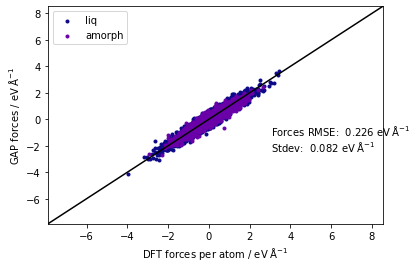

<AxesSubplot:xlabel='DFT forces per atom / $\\mathrm{eV\\;Å^{-1}}$', ylabel='GAP forces / $\\mathrm{eV\\;Å^{-1}}$'>

In [7]:
forces_error(litDB)

In [8]:
ferr = np.array(flatten(litDB.data_dict['F_err_v']))

In [9]:
ferr = ferr.reshape(-1,3)
ferr_norm = np.linalg.norm(ferr.reshape(-1, 3), axis=1)

In [11]:
dia = bulk('Si', 'diamond')

In [12]:
def kernel_mat(cfgs,
                desc=Descriptor('soap average=T l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'),
                zeta=4):
    '''calculates the average/std dev similarity kernel among a set of
    configs.
    should do it more efficiently using symmetry einsum
    '''
    descs = np.array(flatten(desc.calc_descriptor(cfgs)))
    descs = descs.reshape(-1, descs.shape[-1]) # flatten out all the environs
    print(descs.shape)
    k = np.sqrt(2 - 2*np.array(np.einsum('ij,kj', descs, descs)**zeta))
    np.nan_to_num(k, copy=False)
    pca = decomposition.PCA(n_components=2)
    pca.fit(k)
    red = pca.fit_transform(k)

    return k, red


In [14]:
k = kernel_compare(flatten(litDB.V_configs), dia,
               desc=Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'))

(547,)


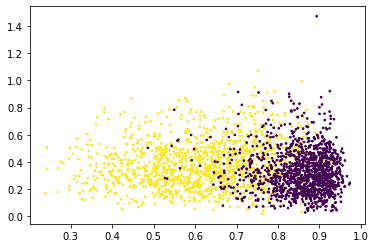

In [19]:
plt.scatter(k, ferr_norm, s=3, marker='x', c=cmap)

In [17]:
cfg_lab = flatten([[i.info['config_type'] for j in range(len(i))] for i in flatten(litDB.V_configs)])

In [63]:
cmap = np.unique(cfg_lab, return_inverse=True)[1]

In [38]:
pot = Potential(param_filename='/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/Si_myDB_64_125_216.xml',
                calc_args='local_gap_variance')

In [41]:
pot.calculate(litDB.V_configs[0][0],
                args_str='local_gap_variance', copy_all_results=True)

In [48]:
gp_var = []
gp_var_grad = []
for i in flatten(litDB.V_configs):
    pot.calculate(i,
                    args_str='local_gap_variance', copy_all_results=True)
    gp_var.append(pot.atoms.arrays['local_gap_variance'])
    gp_var_grad.append(pot.atoms.arrays['gap_variance_gradient'])

In [57]:
grad_s = np.concatenate(gp_var_grad, axis=0)
var_s = np.concatenate(gp_var, axis=0)

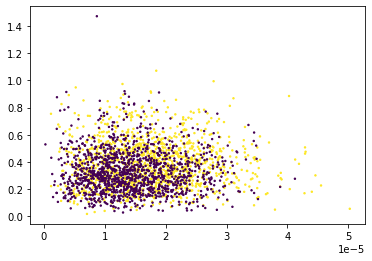

In [66]:
plt.scatter(np.linalg.norm(grad_s, axis=1), ferr_norm, s=2, c=cmap)

In [ ]:
plt.scatter(np.linalg.norm(grad_s, axis=1), k, s=2)


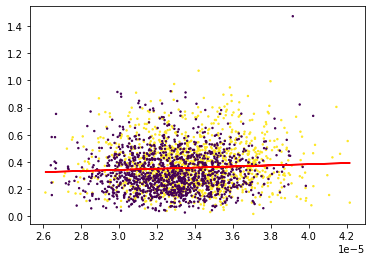

In [73]:
plt.scatter(var_s, ferr_norm, s=2, c=cmap)
plt.plot(var_s, m*var_s + c, 'r')

In [72]:
A = np.vstack([var_s, np.ones(len(var_s))]).T
m, c = np.linalg.lstsq(A, ferr_norm)[0]

<ipython-input-72-0fb3b2028595>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, ferr_norm)[0]


In [74]:
from scipy.stats import pearsonr

<ipython-input-74-fa1e7d9dd839>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(A, ferr_norm)


(array([4.15270783e+03, 2.17391408e-01]),
 array([71.83001385]),
 2,
 array([5.14198406e+01, 1.27655771e-04]))

In [182]:
pearsonr(var_s, ferr_norm)

(0.062426783269231546, 0.0013200262896072258)

In [170]:
pearsonr(np.linalg.norm(grad_s, axis=1), ferr_norm)

(0.024289188864454164, 0.2118334378140808)

In [181]:
pearsonr(var_s, k)

(0.03994968187441616, 0.03997038234928885)

In [168]:
pearsonr(np.linalg.norm(grad_s, axis=1), k)

(-0.10158178086429231, 1.6552743411070796e-07)

In [90]:
desc = Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0')

In [95]:
mean_desc = np.concatenate(desc.calc_descriptor(flatten(litDB.V_configs)), axis=0).mean(axis=0)

In [180]:
k = kernel_compare(flatten(litDB.V_configs), mean_desc,
                   desc=Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'))

(547,)


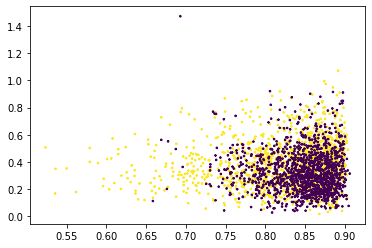

In [109]:
plt.scatter(k, ferr_norm, s=3, marker='x', c=cmap)

In [116]:
gf = np.array(flatten(litDB.gap_v[1])).reshape(-1,3)
qf = np.array(flatten(litDB.qm_v[1])).reshape(-1,3)

In [176]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector, axis=1)[:, np.newaxis]

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.einsum('ij,ij->i', v1_u, v2_u), -1.0, 1.0))

In [177]:
ang_err = angle_between(qf, gf)

In [178]:
pearsonr(ang_err, k)

(-0.0792751244855293, 4.487899333148556e-05)

In [179]:
pearsonr(ang_err, var_s)


(-0.022212881160306435, 0.2535439939833207)

In [187]:
print(k.mean(), k.std())

0.8363387319941057 0.05490302403872639


Select the most extreme environments and look for correlations there (most susceptible to overfitting)

In [234]:
liqs = litDB.V_configs[0]
k_liq = kernel_compare(liqs, mean_desc,
                   desc=Descriptor('soap average=F l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'))
mean_desc_l = np.concatenate(desc.calc_descriptor(liqs), axis=0).mean(axis=0)
ferr_l = np.array(litDB.data_dict['F_err_v'][0])
ferr_l = ferr_l.reshape(-1,3)
ferr_norm_l = np.linalg.norm(ferr_l.reshape(-1, 3), axis=1)
var_l = var_s[0:sum([len(i) for i in litDB.V_configs[0]])]
grad_l = np.linalg.norm(grad_s[0:sum([len(i) for i in litDB.V_configs[0]])], axis=1)

(547,)


In [273]:
outliers = k_liq[(argbool := k_liq < (k_liq.mean()-1*k_liq.std()))]
outliers_g = k_liq[(argbool_g := k_liq > (k_liq.mean()+1*k_liq.std()))]
gf_l = np.array(litDB.gap_v[1][0]).reshape(-1,3)
qf_l = np.array(litDB.qm_v[1][0]).reshape(-1,3)
ang_err_l = angle_between(gf_l, qf_l)

In [274]:
print(pearsonr(var_l[argbool], outliers), '\n')

print(pearsonr(ferr_norm_l[argbool], outliers))
print(pearsonr(ferr_norm_l[argbool], var_l[argbool]))
print(pearsonr(ferr_norm_l[argbool], grad_l[argbool]), '\n')

print(pearsonr(ang_err_l[argbool], outliers))
print(pearsonr(ang_err_l[argbool], var_l[argbool]))
print(pearsonr(ang_err_l[argbool], grad_l[argbool]))

(0.07694285167058593, 0.29007353961833193) 

(0.09022948106386047, 0.21447859785955498)
(-0.1919312875008827, 0.00781623113241208)
(-0.024171193440905677, 0.7399585608252441) 

(-0.018925039635411922, 0.79497512974134)
(-0.15252166012433926, 0.035170122223392705)
(-0.05487320344505174, 0.4508774853943471)


In [271]:
print(pearsonr(ferr_norm_l, k_liq))
print(pearsonr(ferr_norm_l, var_l))
print(pearsonr(ferr_norm_l, grad_l), '\n')

print(pearsonr(ang_err_l, k_liq))
print(pearsonr(ang_err_l, var_l))
print(pearsonr(ang_err_l, grad_l))

(0.0905854080939325, 0.0009762303060705807)
(0.019644095132693794, 0.4754503614387083)
(-0.003906080330446343, 0.8871679896803195) 

(-0.07052388401604816, 0.010318506720519536)
(-0.10657482554153827, 0.00010343732687283775)
(-0.04533072436611913, 0.09945900984245086)


In [213]:
pearsonr(var_s[argbool_g], outliers_g)


(-0.018350343947079663, 0.8073768866093685)

look at the liquid configurations?

Splitting the full DB in two for testing of the custom reg

In [325]:
myDB_full = list(read_xyz('/home/joe/Documents/Ge_od/Potentials/Si_myDB_216/train_64_125_216_full.xyz',
                          index=slice(0,None)))

In [280]:
def reduce_DB(xyz, gen_red=1, ctypes = [None], outfile=None, size_dep_prob={}):
    '''Reduces a database's configuration count for robustness stress-testing
    ctypes: list of str, config_types to keep in new DB. Leave None for all
    size_dist: dict, sizes and their desired relative fractions
    outfile: str, optional custom name for new DB file'''
    r = np.random.rand
    ats = list(read_xyz(xyz, index=slice(0,None)))
    sizes = np.unique([len(i) for i in ats])
    for i in sizes:
        if str(i) not in size_dep_prob.keys():
            size_dep_prob.update({str(i):1})
    ini = sum([len(i) for i in ats])
    keeps = []
    ct = 0; ct_kept = 0; popped = []

    for i in range(len(ats)-1, -1, -1):
        if r() > gen_red and len(ats[i]) != 1:
            popped.append(ats.pop(i))

    for i in range(len(ats)-1, -1, -1):
        if r() > size_dep_prob[str(len(ats[i]))]:
            popped.append(ats.pop(i))

    for i, val in enumerate(ats):
        if (val.info['config_type'] in ctypes or 'isol' in val.info['config_type'] or None in ctypes):
            keeps.append(val)
        else:
            popped.append(val)


    if outfile is None:
        outfile = xyz.split('.')[:-1] + '_red.xyz'
        valfile = xyz.split('.')[:-1] + '_extraval.xyz'

    write_xyz(outfile, keeps)

    print('total {0} popped\n'.format(len(popped)))
    print('final fraction = {:2.2f}%'.format(100*sum([len(i) for i in keeps])/ini))
    print_DB_stats(keeps)

    return keeps, popped

In [326]:
half1 = []; half2 = []

In [320]:
print_DB_stats(myDB_full)


Size statistics:
------------------------------------
size        freq        percentage  
1           1           0.0        
64          250         48.4       
125         50          18.9       
216         50          32.7       

By config types:
------------------------------------
isol             1 atoms
1           1           100.0      
------------------------------------

amorph           6610 atoms
64          50          48.4       
125         10          18.9       
216         10          32.7       
------------------------------------

inter            6610 atoms
64          50          48.4       
125         10          18.9       
216         10          32.7       
------------------------------------

hiT_amorph       6610 atoms
64          50          48.4       
125         10          18.9       
216         10          32.7       
------------------------------------

liq              6610 atoms
64          50          48.4       
125         10          1

In [328]:
for i, val in enumerate(myDB_sorted):
    if i % 2 == 0 or len(val) == 1:
        half1.append(val)
    else:
        half2.append(val)
    if len(val) == 0:
        half2.append()
half2.append(myDB_full[0])

In [330]:
print_DB_stats(half2)

Size statistics:
------------------------------------
size        freq        percentage  
1           1           0.0        
64          125         48.4       
125         25          18.9       
216         25          32.7       

By config types:
------------------------------------
amorph           3305 atoms
64          25          48.4       
125         5           18.9       
216         5           32.7       
------------------------------------

hiT_amorph       3305 atoms
64          25          48.4       
125         5           18.9       
216         5           32.7       
------------------------------------

hiT_liq          3305 atoms
64          25          48.4       
125         5           18.9       
216         5           32.7       
------------------------------------

inter            3305 atoms
64          25          48.4       
125         5           18.9       
216         5           32.7       
------------------------------------

liq           

In [327]:
types = np.unique([i.info['config_type'] for i in myDB_full], return_inverse=True)[1]
myDB_sorted = [i for _,i in sorted(zip(types, myDB_full), key=lambda pair: pair[0])]
sizes = np.unique([len(i) for i in myDB_full], return_inverse=True)[1]
myDB_sorted = [i for _,i in sorted(zip(sizes, myDB_sorted), key=lambda pair: pair[0])]

In [316]:
print_DB_stats(myDB_sorted)

Size statistics:
------------------------------------
size        freq        percentage  
1           1           0.0        
64          250         48.4       
125         50          18.9       
216         50          32.7       

By config types:
------------------------------------
amorph           6610 atoms
64          50          48.4       
125         10          18.9       
216         10          32.7       
------------------------------------

hiT_amorph       6610 atoms
64          50          48.4       
125         10          18.9       
216         10          32.7       
------------------------------------

hiT_liq          6610 atoms
64          50          48.4       
125         10          18.9       
216         10          32.7       
------------------------------------

inter            6610 atoms
64          50          48.4       
125         10          18.9       
216         10          32.7       
------------------------------------

isol          

Need to fit the first potential in order to get some predicted errors in the next

In [332]:
write('Si_half1_control.xyz', half1)

In [ ]:
for i in half2:
    f = 0.1; Fmin = 0.01
    F = np.linalg.norm(i.get_array('dft_forces'), axis=1)
    s = f*vmult_min(F, Fmin)
    i.set_array('force_atom_sigma', s)

write_xyz('Si_half1_custreg', half2)

In [331]:
os.getcwd()

'/home/joe/Documents/Ge_od/Potentials/Si_myDB_reg_testing'